# Matplotlib and pylab inline

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import libraries

In [3]:
import os
import cv2 as cv
import matplotlib.pyplot as plt

from matplotlib import rcParams
from modules.reading import *
from modules.standardization import standardize_image
from modules.preprocessing import preproc_image
from modules.border import left_right_border, top_bottom_border

from pandas import DataFrame

rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = (4, 5)
rcParams["image.cmap"] = "gray"

## Read image

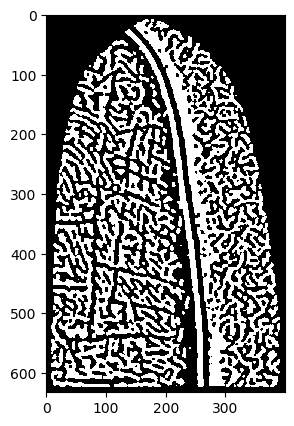

In [4]:
im = read_random_image(RAW_FILE_PATH_BADIM_PANTS)
std_im = standardize_image(im)
prep_im = preproc_image(std_im)

plt.imshow(prep_im)
plt.show()

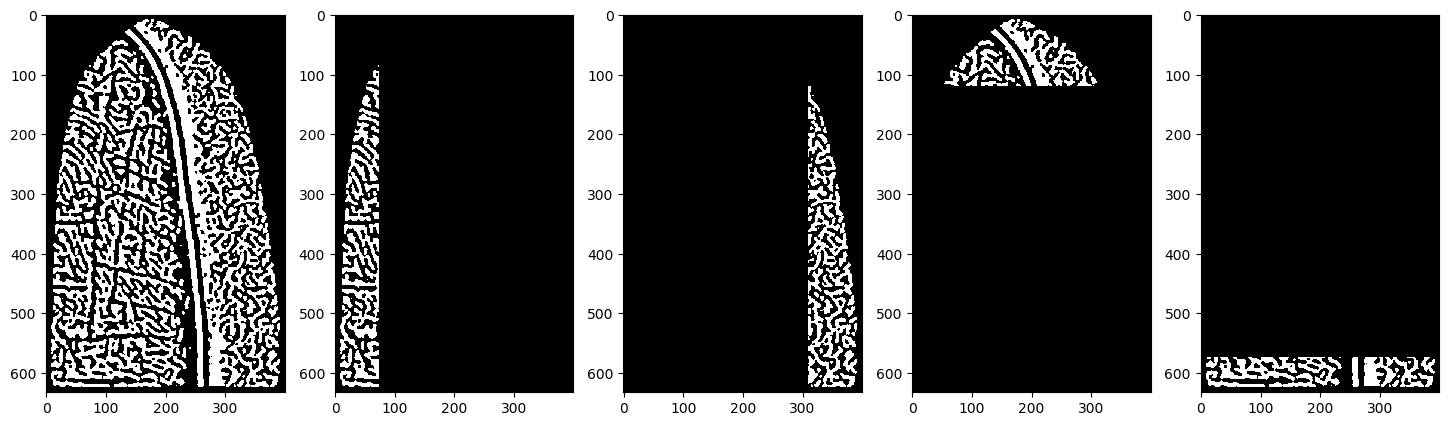

In [5]:
left, right = left_right_border(prep_im)
top, bottom = top_bottom_border(prep_im)

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(18, 5))

ax0.imshow(prep_im)
ax1.imshow(left)
ax2.imshow(right)
ax3.imshow(top)
ax4.imshow(bottom)

plt.show()

In [19]:
def r_max(image, flag='h', percs=[80, 90, 100]):
    
    _, contours, hierarchy = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    radiuses = []
    for cont in contours:
        p, r = cv.minEnclosingCircle(cont)
        radiuses.append(r)
        
    if flag == 'h':
        return np.percentile(radiuses, percs)/image.shape[0]
    elif flag == 'v':
        return np.percentile(radiuses, percs)/image.shape[1]
    else:
        return None

In [20]:
print(r_max(left, flag='h'))
print(r_max(right, flag='h'))
print(r_max(top, flag='v'))
print(r_max(bottom, flag='v'))

[0.04840517 0.05839118 0.15518278]
[0.02237073 0.04655463 0.1692111 ]
[0.0525746  0.09206029 0.19764259]
[0.0993142  0.12690693 0.16334154]


In [21]:
def distance_transform_percentiles(image, percs=[90, 95, 100]):
    
    ds = cv.distanceTransform(image, cv.DIST_L1, cv.DIST_MASK_3)
    ds_ = ds[ds!=0]
    
    return np.percentile(ds_, percs)

In [9]:
print(distance_transform_percentiles(left))
print(distance_transform_percentiles(right))
print(distance_transform_percentiles(top))
print(distance_transform_percentiles(bottom))

[4. 5. 9.]
[4. 4. 8.]
[ 5.  7. 12.]
[ 5.  6. 12.]


In [22]:
def r_max_and_ds_percentiles(image, r_percs=[90, 95, 100], ds_percs=[90, 95, 100]):
    left, right = left_right_border(image)
    top, _ = top_bottom_border(image)
    
    rs_left = r_max(left, flag='h', percs=r_percs)
    rs_right = r_max(right, flag='h', percs=r_percs)
    rs_top = r_max(top, flag='v', percs=r_percs)
    
    ds_left = distance_transform_percentiles(left, percs=ds_percs)
    ds_right = distance_transform_percentiles(right, percs=ds_percs)
    ds_top = distance_transform_percentiles(top, percs=ds_percs)
    
    result = np.array([])
    result = np.append(result, [rs_left, rs_right, rs_top, ds_left, ds_right, ds_top])
    
    return result

In [23]:
r_max_and_ds_percentiles(prep_im)

array([ 0.05839118,  0.07179513,  0.15518278,  0.04655463,  0.06079331,
        0.1692111 ,  0.09206029,  0.14144922,  0.19764259,  4.        ,
        5.        ,  9.        ,  4.        ,  4.        ,  8.        ,
        5.        ,  7.        , 12.        ])

# Use Linear SVC for image classification

## Function for getting data

In [24]:
def get_xy_ims(filepath, images, x, y, y_val=1):
    
    for name in os.listdir(filepath):
        path = filepath + name
        im = cv.imread(path, cv.IMREAD_GRAYSCALE)
        
        if path == None:
            continue
        
        std_im = standardize_image(im)
        prep_im = preproc_image(std_im)
        percentiles = r_max_and_ds_percentiles(prep_im)

        images.append(prep_im)
        x.append(percentiles)
        y.append(y_val)
    

## Get data

In [25]:
images, x, y = [], [], []


get_xy_ims(RAW_FILE_PATH_GOODIM, images, x, y)
get_xy_ims(RAW_FILE_PATH_SCANS, images, x, y)
get_xy_ims(RAW_FILE_PATH_BADIM_PANTS, images, x, y, y_val=0)

images = np.array(images)
x = np.array(x)
y = np.array(y)

DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.026880,0.038336,0.403697,0.052947,0.063449,0.102020,0.171954,0.209052,0.227514,5.0,6.0,9.0,3.0,4.0,6.0,4.0,6.0,9.0
1,0.061598,0.391388,0.429466,0.133523,0.159307,0.180875,0.193420,0.195173,0.199319,6.0,7.0,10.0,3.0,4.0,6.0,4.0,4.0,8.0
2,0.031051,0.039919,0.382336,0.050776,0.058311,0.096796,0.206152,0.254810,0.259615,5.0,6.0,9.0,3.0,3.0,7.0,3.0,3.0,6.0
3,0.060024,0.110600,0.131871,0.047382,0.071725,0.203362,0.132023,0.166675,0.277545,3.0,3.0,6.0,3.0,3.0,6.0,3.0,3.0,4.0
4,0.052258,0.072016,0.166092,0.046240,0.058746,0.087445,0.082119,0.128769,0.171734,4.0,4.0,7.0,4.0,4.0,9.0,4.0,4.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.046201,0.056080,0.181202,0.065632,0.099810,0.133136,0.062520,0.152742,0.164111,5.0,7.0,14.0,4.0,4.0,8.0,5.0,6.0,12.0
61,0.058261,0.067524,0.091212,0.051339,0.077307,0.153897,0.071702,0.095195,0.218636,3.0,4.0,8.0,4.0,4.0,8.0,5.0,6.0,12.0
62,0.065399,0.075176,0.150209,0.040515,0.053512,0.257903,0.053762,0.103190,0.205244,3.0,4.0,7.0,4.0,4.0,8.0,5.0,6.0,12.0
63,0.069850,0.088004,0.118538,0.062601,0.103998,0.259066,0.183347,0.204543,0.224117,3.0,4.0,6.0,5.0,5.0,12.0,5.0,6.0,12.0


## Train LinearSVC and get

In [26]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

svc = LinearSVC(max_iter=5000000)
svc.fit(x, y)

predict = svc.predict(x)
bool_predict = predict != y


for im, good, percs in zip(images[bool_predict], y[bool_predict], x[bool_predict]):
    
    if good:
        print("Является хорошим, считается плохим", percs)
    else:
        print("Является плохим, считается хорошим", percs)
    
    plt.imshow(im, cmap=plt.cm.gray)
    plt.show()

## There is no mistake predictions